In [1]:
import drms
from drms import ServerConfig
from urllib.request import urlretrieve
from urllib.error import URLError, HTTPError
import os
from sunpy.map import Map
import datetime
from datetime import timedelta

from aiapy.calibrate.util import get_correction_table as get_correction_table
from aiapy.calibrate import normalize_exposure, register, update_pointing, correct_degradation
import time

from sunpy.coordinates import frames

import sunpy

from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np

import matplotlib.colors as colors
import matplotlib.pyplot as plt

import cv2

# Define auxiliary functions

In [2]:
def download_latest_94A_map(client):
    
    # Define folder where to save map
    folder = os.path.join('.', 'latest_94A')
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    latency         = 20
    leap_seconds    = 37 
    tai_time_start  = datetime.datetime.now(datetime.timezone.utc) + timedelta(seconds = leap_seconds) - timedelta(minutes = latency)

    # Make the query
    query, segments = client.query('aia.lev1_nrt2[' + tai_time_start.strftime("%Y.%m.%d_%H:%M:%S") + '_TAI/' + str(latency) + 'm]',  key='T_REC, WAVELNTH', seg='image_lev1')

    wavelnth = np.array(query['WAVELNTH'])
    t_rec    = np.array(query['T_REC'])
    segments = np.squeeze(np.array(segments))
    
    idx = np.where(wavelnth == 94)
    idx = idx[0]
    idx = idx[-1]
    
    # Get fits file url
    website_url   = 'https://jsoc1.stanford.edu/'
    fits_file_url = website_url + segments[idx]
    # Define fits file name
    filename = os.path.join(folder, 'aia_lev1_nrt2_94A.fits')
    
    # Download fits file
    try:
        urlretrieve(fits_file_url, filename)
    except (HTTPError, URLError):
        fpath_new = None
        if verbose:
            print("  -> Error: Could not download file")
    
    aia_map = Map(filename)
    aia_map = register(aia_map)
    
    return aia_map

def extract_submaps(aia_map, ar_lon, ar_lat, n_pix = 500):
    
    this_coord = SkyCoord(ar_lon*u.deg, ar_lat*u.deg, frame=frames.HeliographicStonyhurst)

    pix_x = aia_map.world_to_pixel(this_coord).x.value
    pix_y = aia_map.world_to_pixel(this_coord).y.value

    top_right   = aia_map.pixel_to_world((pix_x+n_pix//2-1)*u.pix,(pix_y+n_pix//2-1)*u.pix)
    bottom_left = aia_map.pixel_to_world((pix_x-n_pix//2)*u.pix,(pix_y-n_pix//2)*u.pix)
    
    submap = aia_map.submap(bottom_left, top_right=top_right)
    submap = Map(submap.data.astype(np.int16), submap.meta)
    
    return submap


def plot_aia_map(submap, arnum=False):
    
    titlesize = 15
    labelsize = 15
    if arnum:
        title  = 'AIA 94 A - AR: ' + str(arnum)
    else:
        title  = 'AIA 94 A'
    xlabel = "Solar X [arcsec]"
    ylabel = "Solar Y [arcsec]"


    submap.plot_settings['norm'] = colors.LogNorm(vmin=1, clip=True)#vmin=1e41, vmax=np.max(em_map.data), 
    #em_map.plot_settings['cmap'] = matplotlib.colormaps['CMRmap']
    fig = plt.figure(figsize=(5, 5))

    plt.rc('xtick', labelsize=labelsize)  # fontsize of the tick labels
    plt.rc('axes', titlesize=titlesize)   # fontsize of the axes title
    plt.rc('axes', labelsize=labelsize)  # fontsize of the x and y labels

    ax = plt.subplot(projection=submap)
    im = submap.plot(axes=ax)

    ax.grid(False)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = fig.colorbar(im,cax=cax)#,ticks=cbarticks)
    cbar.ax.tick_params(labelsize=labelsize) 
    #cbar.ax.set_ylabel('EM [cm$^{-3}$ pixel$^{-1}$]')
    
    plt.show()




# Set server configuration

In [3]:
server = ServerConfig(name="JSOC",
                      cgi_baseurl="http://jsoc2.stanford.edu/cgi-bin/ajax/",
                      cgi_show_series="show_series",
                      cgi_jsoc_info="jsoc_info",
                      cgi_jsoc_fetch="jsoc_fetch",
                      cgi_check_address="checkAddress.sh",
                      cgi_show_series_wrapper="showextseries",
                      show_series_wrapper_dbhost="hmidb2",
                      http_download_baseurl="http://jsoc2.stanford.edu/",
                      ftp_download_baseurl="ftp://pail.stanford.edu/export/")

client = drms.Client(server=server,verbose=True)

# Download 94 A image

In [4]:
aia_map = download_latest_94A_map(client)

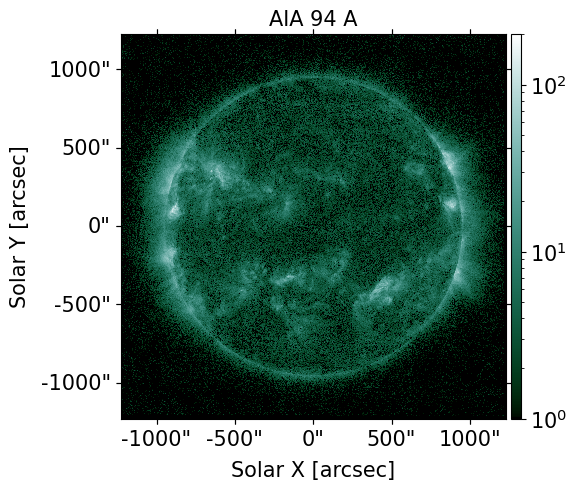

In [5]:
plot_aia_map(aia_map)

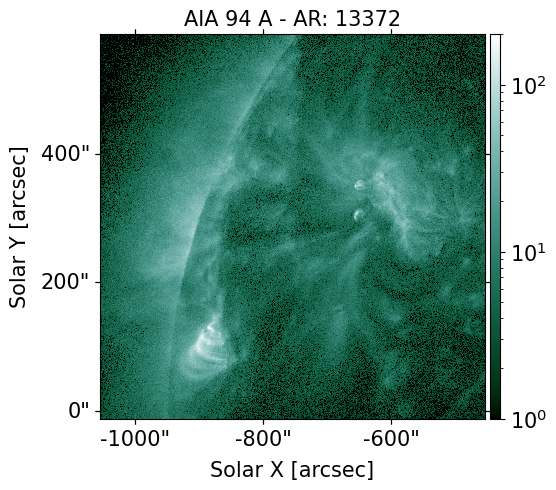

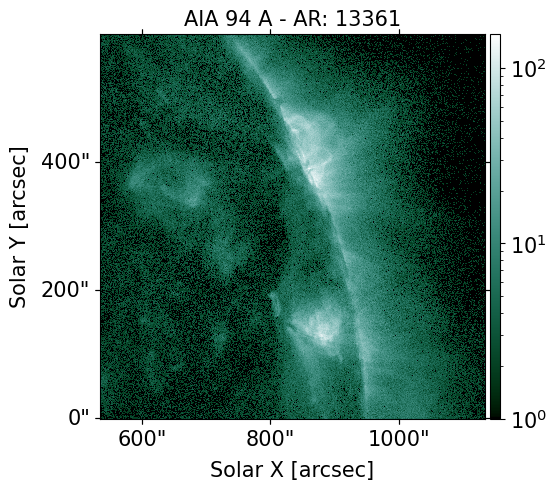

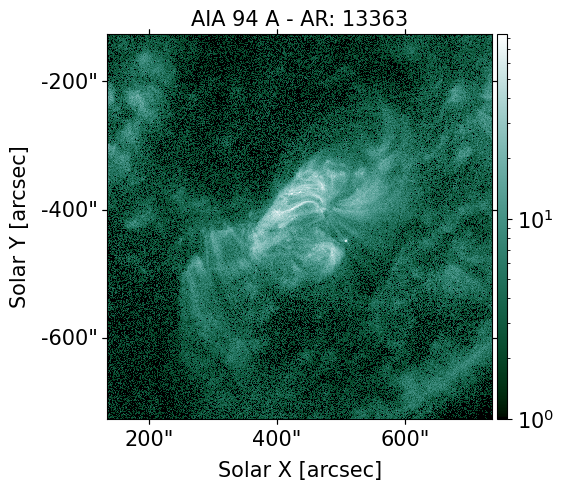

In [11]:
n_ar   = 3
arnum  = [13372,13361,13363]#13368]
ar_lon = [-58,70,30]#,75]
ar_lat = [20,20,-23]#-15]

for i in range(n_ar):
    
    this_submap = extract_submaps(aia_map, ar_lon[i], ar_lat[i], n_pix = 1000)
    plot_aia_map(this_submap, arnum=arnum[i])
